Exercise 1 (40 Points): Use your program to train a LINEAR-kernel SVM classifier that can be used to classify between virginica and setosa. Starting from 0, try several choices of the regular-
ization parameter λ. For each choice of λ, i) adjust the learning rate parameter η to ensure that the gradient descent algorithm actually converges; and 2) draw the scatter plot of the training dataset (virginica and setosa only) and plot the decision boundary in the same figure. Observe how the choice of the regularization parameter λ affects the output predictor and explain what
you have observed to the best of your knowledge.

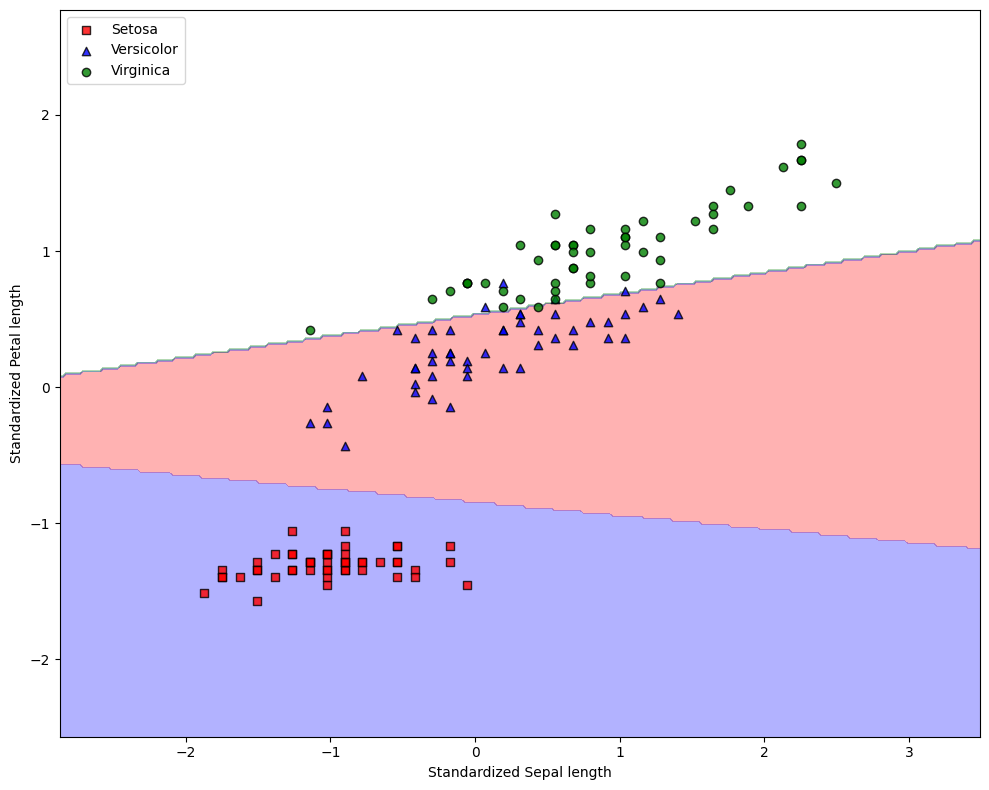

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap


url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
df = pd.read_csv(url, header=None)                                              #Loads data into a DataFrame
X = df.iloc[:, [0, 2]].values                                                   #Extracts feature vectors
y = df.iloc[:, 4].values                                                        #Extracts labels
y = np.where(y == 'Iris-setosa', 0, np.where(y == 'Iris-versicolor', 1, 2))     #Generates labels
X_std = (X - X.mean(axis=0)) / X.std(axis=0)                                    #Standardizing the feature vectors

class KernelSVM:
    def __init__(self, kernel='linear', C=1.0, lr=0.01, epochs=100, degree=3):
        self.kernel = kernel                                                    #Specifying the kernel type
        self.C = C                                                              #Regularization parameter
        self.lr = lr                                                            #Learning rate
        self.epochs = epochs                                                    #Number of epochs for training
        self.degree = degree                                                    #Degree of polynomial for polynomial kernel
        self.alpha = None                                                       #Dual variables
        self.b = 0                                                              #Bias term
        self.X_train = None                                                     #Training feature vectors
        self.y_train = None                                                     #Training labels

    def linear_kernel(self, x1, x2):                                            #Defines linear kernel
        return np.dot(x1, x2)

    def polynomial_kernel(self, x1, x2):                                        #Defines polynomial kernel
        return (1 + np.dot(x1, x2)) ** self.degree

    def kernel_function(self, x1, x2):                                          #Choosing kernel function based on specified kernel type
        if self.kernel == 'linear':
            return self.linear_kernel(x1, x2)
        elif self.kernel == 'polynomial':
            return self.polynomial_kernel(x1, x2)
        else:
            raise ValueError(f"Unknown kernel: {self.kernel}")

    def fit(self, X, y):
        n_samples = X.shape[0]                                                  #Number of samples
        self.alpha = np.zeros(n_samples)                                        #Initializes dual variables to zeros
        K = np.zeros((n_samples, n_samples))                                    #Initializes kernel matrix to zeros
        for i in range(n_samples):                                              #Fills the kernel matrix
            for j in range(n_samples):
                K[i, j] = self.kernel_function(X[i], X[j])

        self.X_train = X                                                        #Stores training feature vectors
        self.y_train = y                                                        #Stores training labels

        for t in range(self.epochs):                                            #Training loop
            for i in range(n_samples):
                eta = 1 / (self.lr * (t + 1))                                   #Adaptive learning rate
                if y[i] * (np.dot(self.alpha * y, K[:, i]) + self.b) < 1:       #Updating dual variables and bias
                    self.alpha[i] += eta * (1 - self.lr * self.C * self.alpha[i])
                    self.b += eta * y[i]
                else:
                    self.alpha[i] -= eta * self.lr * self.C * self.alpha[i]
        return self

    def predict(self, X):
        y_pred = []
        for i in range(len(X)):                                                 #Predicts labels for given feature vectors
            prediction = np.sign(np.sum(self.alpha * self.y_train * self.kernel_function(self.X_train, X[i])) + self.b)
            y_pred.append(prediction)
        return np.array(y_pred)                                                 #Returns predictions as a NumPy array

def one_vs_rest_svm(X, y, kernel='linear', C=1.0, lr=0.01, epochs=1000):        #Definition of one_vs_rest_svm function
    classes = [0, 2]                                                            #0: Setosa, 2: Virginica
    svms = {cls: None for cls in classes}                                       #Dictionary to store trained SVMs
    for cls in classes:
        y_binary = np.where(y == cls, 1, -1)
        svm = KernelSVM(kernel=kernel, C=C, lr=lr, epochs=epochs)               #Creates SVM instance
        svm.fit(X, y_binary)                                                    #Trains SVM
        svms[cls] = svm                                                         #Stores trained SVM in dictionary
    return svms

def plot_decision_boundaries(svms, X, y):
    resolution = 0.02                                                           #Resolution for plotting decision boundaries
    markers = ('s', '^', 'o')                                                   #Markers for different classes
    colors = ('red', 'blue', 'green')                                           #Colors for different classes
    cmap = ListedColormap(colors[:len(np.unique(y))])                           #Colormap for decision boundaries
    flower_names = ['Setosa', 'Versicolor', 'Virginica']                        #Names of flower species

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1                       #Gets min and max values for feature vectors for plotting
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))               #Createsg mesh grid

    Z = np.zeros(xx1.shape)                                                     #Initializes decision boundary matrix to zeros

    for cls, svm in svms.items():
        Z_cls = svm.predict(np.c_[xx1.ravel(), xx2.ravel()]).reshape(xx1.shape)
        Z = np.maximum(Z, Z_cls * (cls + 1))

    plt.figure(figsize=(10, 8))
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap, levels=[-1, 0, 1, 2])

    for idx, cl in enumerate(np.unique(y)):                                     #Fills decision boundary matrix based on predictions from trained SVMs
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=flower_names[cl],
                    edgecolor='black')

    plt.xlabel('Standardized Sepal length')
    plt.ylabel('Standardized Petal length')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

                                                                                #Filters out the virginica and setosa classes from the dataset
X_train = X_std[:, :2]                                                          #Using only the first two standardized features for 2D plotting
y_train = y                                                                     #Using the original labels

                                                                                #Sets the regularization parameter and learning rate
C = 1.5
lr = 0.01
                                                                                #Trains SVMs using one-vs-rest approach
svms = one_vs_rest_svm(X_train, y_train, kernel='linear', C=C, lr=lr, epochs=1000)


plot_decision_boundaries(svms, X_train, y_train)                                #Plots the decision boundaries


I wasn't sure what kind of graph was expected from us, so I created a plot where Virginica is separated from the rest, and Setosa is also separated from the rest, leaving Versicolor as an "obstacle."

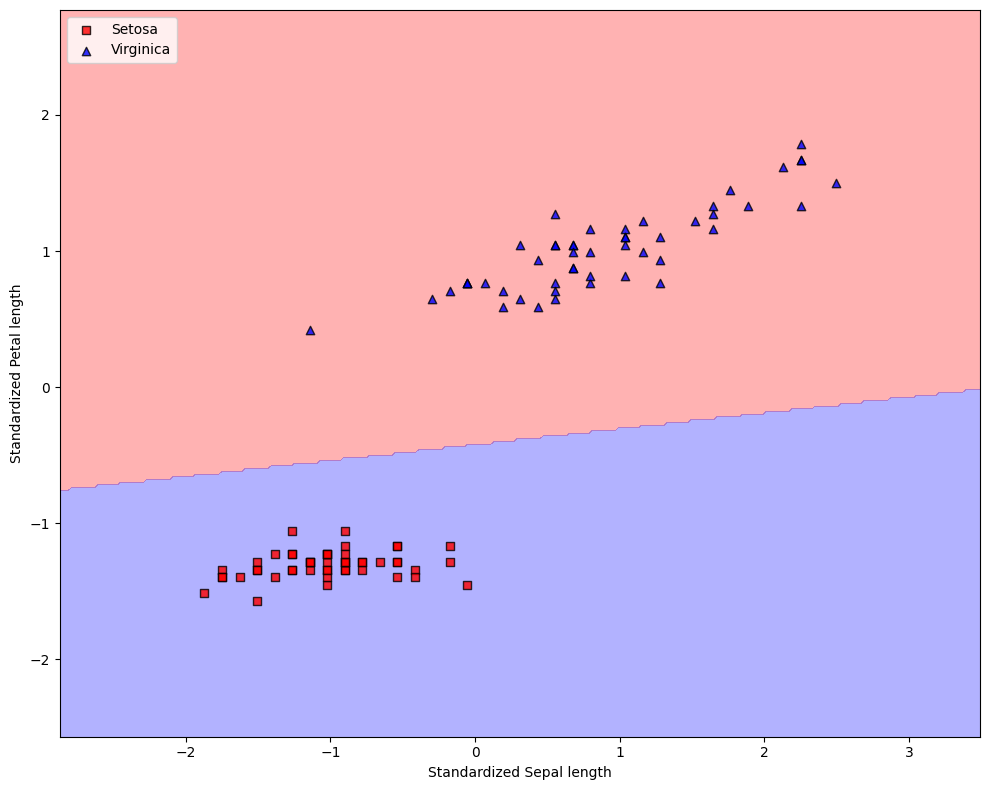

In [15]:
def one_vs_one_svm(X, y, kernel='linear', C=1.0, lr=0.01, epochs=1000):
    y_binary = np.where(y == 0, 1, -1)                                          #Convertes labels to binary (1 for Setosa, -1 for Virginica)
    svm = KernelSVM(kernel=kernel, C=C, lr=lr, epochs=epochs)                   #Creates SVM instance with specified parameters
    svm.fit(X, y_binary)                                                        #Trains the SVM with the feature vectors and binary labels
    return svm

def plot_decision_boundary(svm, X, y):                                          #Definition of plot_decision_boundaries function for plotting decision boundary of SVM
    resolution = 0.02
    markers = ('s', '^', 'o')
    colors = ('red', 'blue', 'green')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    flower_names = ['Setosa', 'Versicolor', 'Virginica']

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))

    Z = svm.predict(np.c_[xx1.ravel(), xx2.ravel()]).reshape(xx1.shape)
    plt.figure(figsize=(10, 8))
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap, levels=[-1, 0, 1])

    for idx, cl in enumerate(np.unique(y)):                                     #Plotting data points for different classes
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=flower_names[cl],
                    edgecolor='black')

    plt.xlabel('Standardized Sepal length')
    plt.ylabel('Standardized Petal length')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

                                                                                #Filters out only the virginica and setosa classes from the dataset
mask = (y == 0) | (y == 2)                                                      #0: Setosa, 2: Virginica
X_train_filtered = X_std[mask, :2]                                              #Applys the mask to feature vectors and keeping only first two features for 2D plotting
y_train_filtered = y[mask]                                                      #Applys the mask to labels
                                                                                #Sets the regularization parameter and learning rate
C = 0.01
lr = 0.001

                                                                                #Trains SVM using one-vs-one approach
svm = one_vs_one_svm(X_train_filtered, y_train_filtered, kernel='linear', C=C, lr=lr, epochs=1000)

                                                                                #Plots the decision boundary
plot_decision_boundary(svm, X_train_filtered, y_train_filtered)

When λ >= 10, the decision boundary situates itself equidistantly between classes, reflecting a simpler model with a maximized margin. At λ=0.01, the decision boundary slants, indicating a more complex model driven to minimize classification error. Further lowering of λ causes the decision boundary to descend, a manifestation of the model overfitting to the training data, chasing outliers or noise due to an extremely low regularization effect.

Exercise 2 (40 Points): Use your program to train a POLYNOMIAL-kernel SVM classifier that can be used to classify between versicolor and the rest. Try several choices of the regularization
parameter λ and the degree of the polynomial kernel k. Pick one combination of λ and k that you feel performs the best. Draw the scatter plot of the training dataset (versicolor and rest)
and plot the decision boundary in the same figure. Compare the performance of your kernel SVM predictor with the Adaline that you trained from the previous assignment in terms of the training error rate.

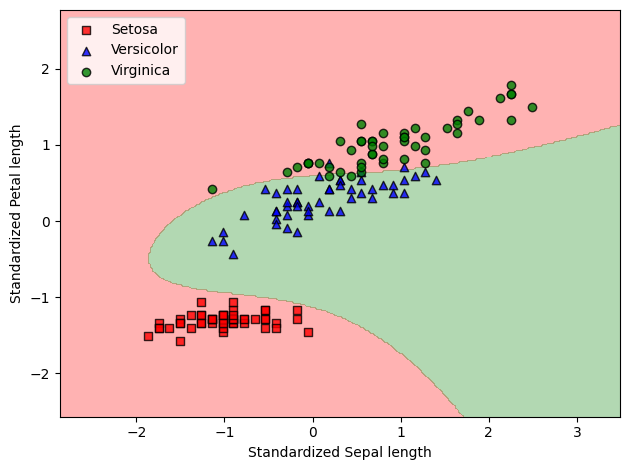

In [35]:
def one_vs_rest_svm(X, y, kernel='linear', C=1.0, lr=0.01, epochs=1000, degree=3):
    classes = [1]                                                               #1: Versicolor
    svms = {cls: None for cls in classes}                                       #Creates an empty dictionary to store the SVM for each class
    for cls in classes:
        y_binary = np.where(y == cls, 1, -1)
        svm = KernelSVM(kernel=kernel, C=C, lr=lr, epochs=epochs, degree=degree)#Creates SVM instance with specified parameters
        svm.fit(X, y_binary)                                                    #Trains the SVM with the feature vectors and binary labels
        svms[cls] = svm
    return svms

def plot_decision_boundaries(svms, X, y):                                       #Definition of plot_decision_boundaries function for plotting decision boundary of SVM
    resolution = 0.02
    markers = ('s', '^', 'o')
    colors = ('red', 'blue', 'green')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    flower_names = ['Setosa', 'Versicolor', 'Virginica']

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))

    Z = svms[1].predict(np.c_[xx1.ravel(), xx2.ravel()]).reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap, levels=[-1, 0, 1])

    for idx, cl in enumerate(np.unique(y)):                                     #Plotting data points for different classes
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=flower_names[cl],
                    edgecolor='black')

    plt.xlabel('Standardized Sepal length')
    plt.ylabel('Standardized Petal length')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

                                                                                #Filters out the virginica and setosa classes from the dataset
X_train = X_std[:, :2]                                                          #Using only the first two standardized features for 2D plotting
y_train = y                                                                     #Using the original labels

                                                                                #Sets the regularization parameter and learning rate
C = 1
lr = 0.1

                                                                                #Trains SVMs using one-vs-rest approach with a polynomial kernel
svms = one_vs_rest_svm(X_train, y_train, kernel='polynomial', C=C, lr=lr, epochs=1000, degree=3)

                                                                                #Plots the decision boundaries
plot_decision_boundaries(svms, X_train, y_train)